# DEW Demo for Kev

Right now pyDEW has to be run either in binder or from a docker container. Hopefully it will be available on the ENKI server soon. If you run a Mac or Linux computer and have ENKI thermoengine installed you could also run pyDEW locally.

The main challenge with running these calculations is figuring out how to set up the calculation to solve the problem you are interested in. At the moment all calculations are run using either the EQ3 or EQ6 fortran programmes, which pyDEW provides a wrapper to. This means (until I have finished the complete integration with ENKI) that you are constrained by the way these programmes allow you to do calculations.

*EQ3* will calculate the composition and speciation of a fluid given that each element in the system is constrained in some way:
1. By setting the molality of the element in the solution
2. By setting it to be in equilibrium with a particular pure mineral
3. By setting it to be in equilibrium with a component of a solid solution, and additionally specifying the composition of that solid solution.

So if you know the rock the fluid is in equilibrium with, then this is a straightforward calculation. BUT... in the scenarios you are thinking about you would need to know the mineral assemblage and mineral compositions of the rock at every pressure and temperature you are interested in. There are two ways people have approached this. One is to just *know* the sort of the rock they are equilibrating with, i.e., what are the minerals in a serpentinite at these sorts of conditions, and what is a representative composition for them. This is ok if the mineralogical variability is quite straightforward, or you're trying to recreate a very specific system. Second, people have looked to phase equilibrium calculations (e.g., using THERMOCALC, TD or Perplex) and used the results from there. The problem with this approach is the phase assemblage was found without the fluid (or a realistic model for the fluid), and yet it will then be used to calculate a fluid... So this could be a problem! 

*EQ6* calculates reactions between fluids and minerals, i.e., it is finding the equilibrium state. It requires:
1. An initial fluid composition (calculated with EQ3)
2. Reactants- could be minerals in the right proportions and compositions to represent the bulk composition, or NEW! An actual bulk composition (in mols or wtpt)
3. Reaction progress- how many moles of reactants should be added.

So this means EQ6 can effectively be used as a free-energy minimiser, and find the equilibrium state for a given bulk composition provided there is a fluid present (and the fluid doesn't end up with an extreme composition).

I think EQ6 is the way to go here. One thing to bear in mind though is how close to reality the calculation will be. Reaction progress is related to the fluid:rock ratio in the system (at some point pyDEW will calculate this for you- I ran out of time!). Sometimes the fluid ends up being saturated in the minerals/composition being added- i.e., its composition no longer depends on the fluid:rock ratio. This seems to be the case if the system is simple. For more complex systems this is unlikely to happen. So you essentially need to pick a fluid-rock ratio. Ideally you would do this in a way thats informed by the bulk composition of the system (i.e., how much water is actually in the rock), though even this could get you in trouble- what if fluid is percolating from below? Unfortunately, EQ6 does not conserve the mass of H2O, its algorithm doesn't allow that. This problem will be solved (hopefully by Goldschmidt) when I finish the complete integration with ENKI. ENKI can then take care of the mass conservation.

Another general point with DEW calculations is that it is very important to check through the results and make sure the predictions make sense. Do the mineral compositions left behind look reasonable? Is the fluid reasonable? You may need to add or remove different species from the fluid, or minerals, depending on the conditions you are running the calculations at. This aspect will most likely be the most time consuming bit of the whole process, but it is really vital to making sure the results are useful.

The Perplex software has a version of DEW built in which people have used. However, I would be very cautious about using it because I suspect there are a lot of database inconsistencies.

## Calculation preliminaries
First, import the required modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyDEW
import pandas as pd

Create a DEW system (see tutorials and docs for more information on this). Here we will use the default system:

*Note the pandas warnings are coming from the thermoengine module not pyDEW, so I can't easily fix this, you can mute them if they get too annoying*

In [2]:
system = pyDEW.System()

/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecate

## Calculations

Set up a list of pressures and temperatures to run at:

In [3]:
run_conditions = np.array([[700.0, 710.0, 720.0, 730.0, 740.0, 750.0], 
                           [10000, 10100, 10200, 10300, 10400, 10500]])

Starting rock composition (expressed in terms of pure minerals). As long as it sums to the bulk composition the actual minerals don't matter- they will react to get the equilibrium mineral assemblage:

*I don't remember which paper this came from, but I suspect you will want to change this anyway*

In [4]:
# bulkcomp_oxides = {'Na2O':  0.021,
#                    'MgO':  44.43,
#                    'K2O':   0.005,
#                    'CaO':   1.2,
#                    # 'TiO2':  0.02,
#                    'FeO':   8.10,
#                    # 'MnO':   0.13,
#                    # 'Cr2O3': 0.68,
#                    'SiO2': 43.56,
#                    'Al2O3': 1.86
#                   }

# MORB from Guillaume:
bulkcomp_oxides = {'Na2O':  0.042,
                   'MgO':  0.189,
                   'K2O':   0.002,
                   'CaO':   0.189,
                   # 'TiO2':  0.0,
                   'FeO':   0.148,
                   # 'MnO':   0.13,
                   # 'Cr2O3': 0.68,
                   'SiO2': 0.842,
                   'Al2O3': 0.154
                  }

Create a dilute fluid to react the mineral assemblage with. This needs to have the same chemical system as the rock, so I will make it dilute in each element. The results will be sensitive to the amount of Cl- added here (which is not in the other minerals, but is probably important. S may also be important.

In [5]:
molalities = {'H4SIO4(AQ)': 0.001,
              'NA+': 0.001,
              'MG+2': 0.001,
              'FE+2': 0.001,
              'CA+2': 0.001,
              'K+': 0.001,
              'AL+3': 0.001,
              'CL-': 0.001,
              'CO2(AQ)': 0.001}

# Use nxmods for altering the data file that runs the calculation, e.g. for
# removing a phase or species.
nxmods = [
          ['CPX_SUBCALCIC(SS)',3,-1,0], # Probably don't want this in models
         ]

fluid = pyDEW.Fluid(system, 
                    run_conditions[0][0] + 273.15, 
                    run_conditions[1][0], 
                    molalities=molalities, 
                    nxmods=nxmods,
                    uacion='CL-',
                    eq3_executable_name='EQ3_longoutput' # I need this to run on my dev install, delete on a normal install.
                   )

In [7]:
reaction = pyDEW.Reaction(fluid, 
                          run_conditions[0][0] + 273.15, 
                          run_conditions[1][0], 
                          bulk_composition = bulkcomp_oxides,
                          bulk_composition_units = 'wtpt_oxides',
                          mols_bulk_composition = 1000.0, # This controls how much of the bulk composition to add
                          zimax=10000.0, # This number must be greater than or equal to the mols of bulk composition to add
                          eq6_executable_name='EQ6_longmaybe') # I need this to run on my dev install, delete on a normal install.

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [56]:
reaction.elements

,H,Al,Ca,C,Si,Cl,Fe,K,Mg,Na
Log zi,,,,,,,,,,
-999.00,2.0455,-3.1148,-3.0000,-3.0000,-3.0000,-3.0000,-6.4928,-3.0000,-3.2167,-3.0000
-6.05,2.0455,-3.1148,-3.0000,-3.0000,-2.9999,-3.0000,-6.4928,-3.0000,-3.2167,-3.0000
-5.95,2.0455,-3.1148,-3.0000,-3.0000,-2.9999,-3.0000,-6.4927,-3.0000,-3.2167,-3.0000
-5.60,2.0455,-3.1148,-3.0000,-3.0000,-2.9998,-3.0000,-6.4927,-3.0000,-3.2167,-3.0000
-5.40,2.0455,-3.1148,-3.0000,-3.0000,-2.9997,-3.0000,-6.4927,-3.0000,-3.2167,-3.0000
...,...,...,...,...,...,...,...,...,...,...
2.80,2.0486,-1.3538,-2.7108,-2.9146,-0.7762,-2.9146,-5.4655,-2.1578,-4.9864,-1.1223
2.85,2.0487,-1.3269,-2.7302,-2.9034,-0.7691,-2.9034,-5.4404,-2.1744,-5.0035,-1.0883
2.90,2.0488,-1.3011,-2.7487,-2.8905,-0.7620,-2.8905,-5.4161,-2.1902,-5.0194,-1.0563


In [8]:
def extract_mols_el_from_mineral(system, element, mineral):
    """
    Calculate the moles of H2O stored in a pure mineral.
    
    Parameters
    ----------
    system : pyDEW.System
        The system used in the calculation
    element : str
        The name of the element to look up
    mineral : str
        The name of the mineral (must match with the name in the system).
    
    Returns
    -------
    float
        The mols of H2O stored in the mineral
    """
    periodic_order = [None, 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na',
                     'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V',
                     'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se',
                     'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
                     'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba',
                     'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho',
                     'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt',
                     'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac',
                     'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
                     'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg']
    # Find index for element:
    i = periodic_order.index(element)
    # Get array with moles of every element:
    return system.minerals_dict[mineral].props['element_comp'][0,i]

def calculate_mols_O(system, species_concs):
    """
    """
    mols = 55.5086815578 # Moles of O in solvent
    
    for sp in species_concs.index:
        if sp != 'H2O':
            mols += (system.species[sp].props['element_comp'][0,8]
                     * 10**species_concs[sp])
        
        if sp in system.hydrated_species:
            mols += system.hydrated_species[sp] * 10**species_concs[sp]
            
    return mols
        

def calculate_mols_elements_in_system(system, elements, species_concs, minerals, solid_solutions):
    """
    Calculate the total moles of H stored in a single EQ6 iteration
    
    Parameters
    ----------
    system : pyDEW.System
        The system used in the calculation
    fluid_elements : pandas.Series
        The molalities of each element in the fluid
    minerals : pandas.Series
        The moles of minerals present
    solid_solutions : pandas.Series
        The mole fraction of endmembers in solid solutions.
    
    Returns
    -------
    float
        The total moles of H2O in the system.
    """
    
    mol_elements = {}
    
    for el in list(reaction.elements.columns) + ['O']:
        if el == 'O':
            mols = calculate_mols_O(system, species_concs)
        else:
            mols = 10**elements[el]
            

        for mineral in minerals.index:
            if np.isnan(minerals[mineral]) == False:
                # Check if solid solution
                if mineral in system.solid_solutions:
                    for endm in system.solid_solutions[mineral]:
                        if np.isnan(solid_solutions[endm]) == False:
                            mols += extract_mols_el_from_mineral(system, el, endm, ) * 10**minerals[mineral] * solid_solutions[endm]
                # Pure mineral:
                else:
                    mols += extract_mols_el_from_mineral(system, el, mineral, ) * 10**minerals[mineral]
    
        mol_elements[el] = mols
                
    return pd.Series(mol_elements)
    
    
def calculate_bulk_comp_mol_elements(reaction, system):
    elements_in_system = list(reaction.elements.columns) + ['O']
    df = pd.DataFrame(columns=elements_in_system)
    df.index.name = 'log zi'
    
    for logzi in reaction.elements.index:
        runcalc = True
        if logzi in reaction.elements.index:
            elements = reaction.elements.loc[logzi]
        else:
            runcalc = False
        if runcalc is True and logzi in reaction.species_concs.index:
            species_concs = reaction.species_concs.loc[logzi]
        else:
            runcalc = False
        if runcalc is True and logzi in reaction.minerals.index:
            minerals = reaction.minerals.loc[logzi]
        else:
            runcalc = False
        if logzi in reaction.solid_solutions.index:
            solid_solutions = reaction.solid_solutions.loc[logzi]
        else:
            solid_solutions = None
        
        if runcalc is True:
            mols = calculate_mols_elements_in_system(system, elements, species_concs, minerals, solid_solutions)
            mols = mols / mols.sum()

            df.loc[logzi] = mols
    
    return df


In [9]:
mol_elm = calculate_bulk_comp_mol_elements(reaction, system)

In [10]:
mol_elm

,H,Al,Ca,C,Si,Cl,Fe,K,Mg,Na,O
log zi,,,,,,,,,,,
-999.00,0.666624,0.000006,0.000006,6.003144e-06,0.000006,6.003144e-06,0.000006,0.000006,0.000006,0.000006,0.333322
-6.05,0.666624,0.000006,0.000006,6.003144e-06,0.000006,6.003144e-06,0.000006,0.000006,0.000006,0.000006,0.333322
-5.95,0.666624,0.000006,0.000006,6.003144e-06,0.000006,6.003144e-06,0.000006,0.000006,0.000006,0.000006,0.333322
-5.60,0.666624,0.000006,0.000006,6.003144e-06,0.000006,6.003144e-06,0.000006,0.000006,0.000006,0.000006,0.333322
-5.40,0.666624,0.000006,0.000006,6.003144e-06,0.000006,6.003144e-06,0.000006,0.000006,0.000006,0.000006,0.333322
...,...,...,...,...,...,...,...,...,...,...,...
3.00,0.117198,0.006356,0.003721,1.142469e-06,0.126065,1.142469e-06,0.019598,0.000021,0.191617,0.000142,0.535279
3.05,0.108806,0.006453,0.003777,1.083168e-06,0.127988,1.083168e-06,0.019898,0.000021,0.194549,0.000145,0.538361
3.10,0.101115,0.006543,0.003830,1.034568e-06,0.129754,1.034568e-06,0.020172,0.000021,0.197228,0.000148,0.541187


To convert into wt% oxides requires making some decisions about which oxides to project to and how to deal with elements like Cl. It is simpler if you just want to know the wt% of H$_2$O (assuming all H is present in the bulk as H$_2$O, rather than in H$_2$ or HCl). I am working on a more general solution to this.

First, convert to mass:

In [ ]:
periodic_order = [None, 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na',
                     'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V',
                     'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se',
                     'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
                     'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba',
                     'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho',
                     'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt',
                     'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac',
                     'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
                     'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg']

periodic_weights = np.array([
        0.0, 1.0079, 4.00260, 6.94, 9.01218, 10.81, 12.011, 14.0067, 15.9994,
        18.998403, 20.179, 22.98977, 24.305, 26.98154, 28.0855, 30.97376, 32.06,
        35.453, 39.948, 39.102, 40.08, 44.9559, 47.90, 50.9415, 51.996, 54.9380,
        55.847, 58.9332, 58.71, 63.546, 65.38, 69.735, 72.59, 74.9216, 78.96,
        79.904, 83.80, 85.4678, 87.62, 88.9059, 91.22, 92.9064, 95.94, 98.9062,
        101.07, 102.9055, 106.4, 107.868, 112.41, 114.82, 118.69, 121.75,
        127.60, 126.9045, 131.30, 132.9054, 137.33, 138.9055, 140.12, 140.9077,
        144.24, 145., 150.4, 151.96, 157.25, 158.9254, 162.50, 164.9304, 167.26,
        168.9342, 173.04, 174.967, 178.49, 180.9479, 183.85, 186.207, 190.2,
        192.22, 195.09, 196.9665, 200.59, 204.37, 207.2, 208.9804, 209., 210.,
        222., 223., 226.0254, 227., 232.0381, 231.0359, 238.029, 237.0482, 244.,
        243., 247., 247., 251., 254., 257., 258., 259., 260., 260., 260., 263.])


wt_elm = mol_elm.copy()
for el in mol_elm.columns:
    wt_elm[el] = mol_elm[el] * periodic_weights[periodic_order.index(el)]


wt_elm = wt_elm.div(wt_elm.sum(axis=1), axis=0)

wt_elm

,H,Al,Ca,C,Si,Cl,Fe,K,Mg,Na,O
log zi,,,,,,,,,,,
-999.00,0.111860,0.000027,0.000040,1.200419e-05,0.000028,0.000035,0.000056,0.000039,0.000024,0.000023,0.887856
-6.05,0.111860,0.000027,0.000040,1.200419e-05,0.000028,0.000035,0.000056,0.000039,0.000024,0.000023,0.887856
-5.95,0.111860,0.000027,0.000040,1.200419e-05,0.000028,0.000035,0.000056,0.000039,0.000024,0.000023,0.887856
-5.60,0.111860,0.000027,0.000040,1.200418e-05,0.000028,0.000035,0.000056,0.000039,0.000024,0.000023,0.887856
-5.40,0.111860,0.000027,0.000040,1.200418e-05,0.000028,0.000035,0.000056,0.000039,0.000024,0.000023,0.887856
...,...,...,...,...,...,...,...,...,...,...,...
3.00,0.006455,0.009372,0.008150,7.498707e-07,0.193482,0.000002,0.059811,0.000044,0.254503,0.000178,0.468001
3.05,0.005932,0.009418,0.008189,7.037275e-07,0.194438,0.000002,0.060108,0.000044,0.255772,0.000180,0.465915
3.10,0.005462,0.009461,0.008226,6.659532e-07,0.195303,0.000002,0.060374,0.000044,0.256903,0.000183,0.464041


Now calculate wt% of H$_2$O

In [33]:
H2O_wtpt = (wt_elm['H'] + wt_elm['H']/1.0079*15.999/2)/wt_elm.sum(axis=1) * 100
H2O_wtpt

log zi
-999.00    99.966653
-6.05      99.966650
-5.95      99.966648
-5.60      99.966645
-5.40      99.966642
             ...    
 3.00       5.768743
 3.05       5.301290
 3.10       4.881116
 3.15       4.503458
 3.20       4.162745
Length: 172, dtype: float64

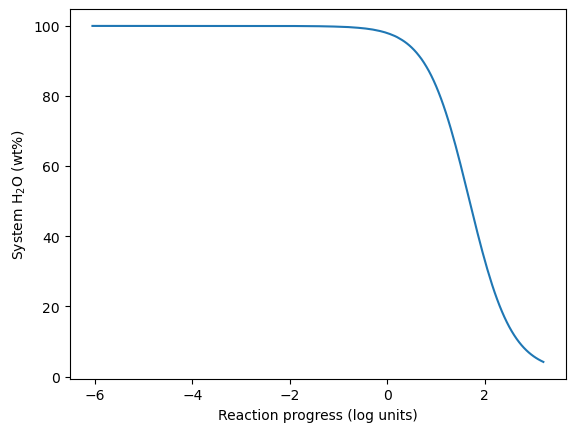

In [40]:
f, a = plt.subplots()

a.plot(H2O_wtpt.index[1:], H2O_wtpt.iloc[1:])

a.set_ylabel('System H$_2$O (wt%)')
a.set_xlabel('Reaction progress (log units)')

plt.show()

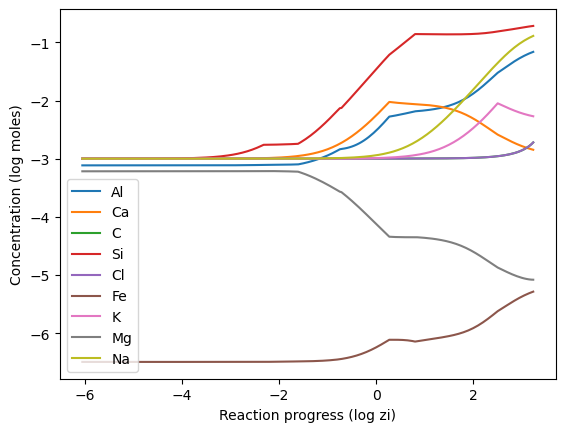

In [14]:
f,a = plt.subplots()
for el in list(reaction.elements.columns):
    a.plot(reaction.elements.index[1:], reaction.elements[el].iloc[1:], label=el)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Concentration (log moles)')
plt.show()

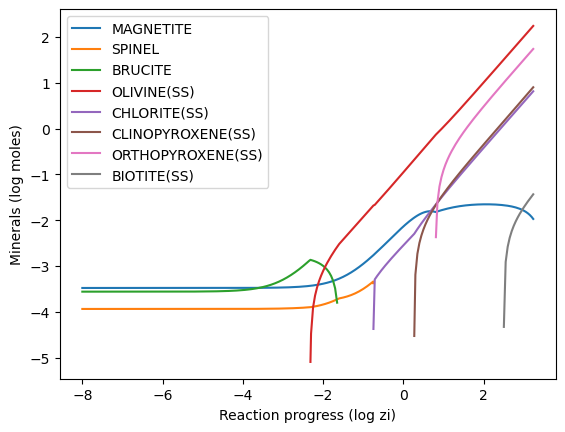

In [15]:
f,a = plt.subplots()
for mi in list(reaction.minerals.columns):
    a.plot(reaction.minerals.index[1:], reaction.minerals[mi].iloc[1:], label=mi)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Minerals (log moles)')
plt.show()

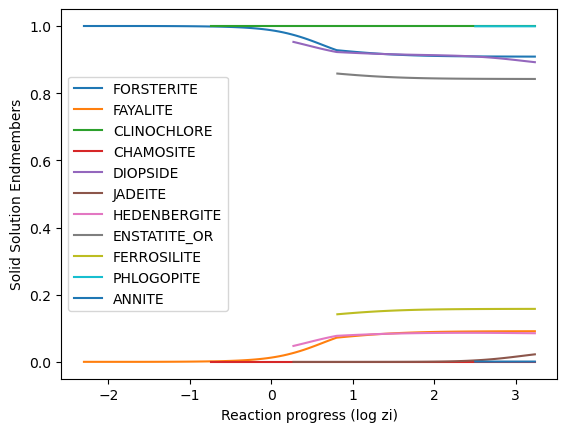

In [16]:
f,a = plt.subplots()
for mi in list(reaction.solid_solutions.columns):
    a.plot(reaction.solid_solutions.index[1:], reaction.solid_solutions[mi].iloc[1:], label=mi)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Solid Solution Endmembers')
plt.show()

If you want to start a new calculation from the composition of the solid from the previous step you will need to calculate this from the minerals and solid solutions present at the end of the previous run, combined with their formulae. The easiest place to check this is to go into the `working` directory in the folder and find the `DATA0` file. You could also automate something that uses the properties in `System` to get the formulae.

In [17]:
reaction.minerals.iloc[-1]

MAGNETITE           -1.9715
SPINEL                  NaN
BRUCITE                 NaN
OLIVINE(SS)          2.2395
CHLORITE(SS)         0.8138
CLINOPYROXENE(SS)    0.9014
ORTHOPYROXENE(SS)    1.7372
BIOTITE(SS)         -1.4338
Name: 3.2369, dtype: float64